In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

In [13]:
dbuilder_path = None # change accordingly

import sys
sys.path.append(dbuilder_path)

from src import extract_uniprot     as uniprot
from src import extract_uniref      as uniref

MONGO_HOST = "10.1.0.202"
MONGO_PORT = 30077

uniprot_db = uniprot.uniprot_extractor(mongo_host = MONGO_HOST, mongo_port = MONGO_PORT, name='UniProt')
uniprot_db_titles = uniprot.uniprot_extractor(mongo_host = MONGO_HOST, mongo_port = MONGO_PORT, name='UniProt_updated_names')
uniref_db = uniref.uniref_extractor(mongo_host = MONGO_HOST, mongo_port = MONGO_PORT)

In [14]:
subgraphs_summary = pd.read_csv('data_generated/AFDB90v4_subgraphs_summary.csv')
subgraphs_summary = subgraphs_summary.set_index('Subgraph')

AFDB90 = pd.read_csv('data_generated/AFDB90v4_all_data.csv', index_col=0)

In [15]:
def map_ids_to_uniprot(ids, chunck_len = 100, mode='menzi', uniprot_db_titles=None):
    
    new_results = {'uniprot_acc': [], 'protein_name': [], 'name_source': [], 'name_type':[], 'taxonId': []}
    
    for i in range(0, len(ids), chunck_len):
        chunck = ids[i: i+chunck_len]
        
        if mode == 'menzi':
            uniprot_docs = uniprot_db_titles.col.find({'_id': {'$in': chunck}})
            for doc in uniprot_docs:
                new_results['uniprot_acc'].append(doc['_id'])
                new_results['protein_name'].append(doc['data']['NAME']['TITLE'])
                new_results['name_source'].append(doc['data']['NAME']['SOURCE'])
                new_results['name_type'].append(np.nan)
                new_results['taxonId'].append(np.nan)
            
        else:
            pass
        
    results = pd.DataFrame(new_results)

    return results

In [17]:
outfolder = 'data_generated/uniprot_naming_assessment'

if not os.path.isdir(outfolder):
    os.mkdir(outfolder)

collected_counts = {'Subgraph': [], 'No. entries': [], 'No. unique names': [], 
                    'Word diversity': [], 'Darkness class': [], 'Most freq. source': [], 'Source freq': []}

for level in ['fully dark', 'fully bright']:
    
    if level == 'fully dark':
        target_galaxies = subgraphs_summary.loc[(subgraphs_summary.Avg_darkness <= 5)].sort_values(by='N_members', ascending=False)
    elif level == 'fully bright':
        target_galaxies = subgraphs_summary.loc[(subgraphs_summary.Avg_darkness >= 95)].sort_values(by='N_members', ascending=False)

    n = len(target_galaxies)
    count = 0
    
    for node_class in target_galaxies.index:
        count +=1

        outfile = '{}/AFDB90v4_subgraph_{}_uniprot_names_08022023.csv'.format(outfolder, node_class)

        if count %100 == 0:
            print(count,n, 'CURR NODE CLASS:', node_class)
                          
        if not os.path.isfile(outfile):
            
            pass
        
#             target_unirefs = list(AFDB90.loc[AFDB90.subgraphID == node_class].index)
#             target_accs = []

#             uniref_docs = uniref_db.col.find({'_id': {'$in': target_unirefs}})
#             for doc in uniref_docs:
#                 target_accs += [i.split('_')[1] for i in doc['data']['UNIREF']['UniRef100']] 

#             target_accs = list(set([i for i in target_accs if not i.startswith('UP')]))

#             if len(target_accs) > 50:

#                 if count %100 == 0:
#                     print(count,n, 'CURR NODE CLASS:', node_class, '  ... {} total targets'.format(len(target_accs)))

#                 uniprot_data = map_ids_to_uniprot(target_accs, chunck_len=5000, mode='menzi', uniprot_db_titles=uniprot_db_titles)
#                 uniprot_data.to_csv(outfile, sep=',')

#                 uniprot_docs = uniprot_db.col.find({'_id': {'$in': target_accs}})

#                 out_fasta = '{}/AFDB90v4_subgraph_{}_uniprot_names_08022023.fasta'.format(outfolder, node_class)
#                 with open(out_fasta, 'w') as outf:
#                     for doc in uniprot_docs:
#                         outf.write('>{}\n{}\n'.format(doc['_id'], doc['data']['SEQ']))

        if os.path.isfile(outfile):
            uniprot_data = pd.read_csv(outfile, index_col=0)

            words = []
            names = []
            for name in uniprot_data['protein_name']:
                name = name.lower()
                for to_mask in ['protein', 'domain', 'containing', 'superfamily', 'family']:
                    name.replace(to_mask, '')
                    
                name = name.replace('-',' ')
                words += name.split()
                
            tmp = uniprot_data['name_source'].value_counts(normalize =True).sort_values(ascending=False)
                
            collected_counts['Subgraph'].append(node_class)
            collected_counts['Darkness class'].append(level)
            collected_counts['No. entries'].append(len(uniprot_data))
            collected_counts['No. unique names'].append(len(set(uniprot_data['protein_name'])))
            collected_counts['Word diversity'].append(len(set(words))/len(words))
            
            collected_counts['Most freq. source'].append(tmp.head(1).index[0])
            collected_counts['Source freq'].append(float(tmp.head(1)*100))

collected_counts = pd.DataFrame(collected_counts)
collected_counts = collected_counts.set_index('Subgraph')

100 46318 CURR NODE CLASS: 1224
200 46318 CURR NODE CLASS: 2277
300 46318 CURR NODE CLASS: 3305
400 46318 CURR NODE CLASS: 4255
500 46318 CURR NODE CLASS: 4999
600 46318 CURR NODE CLASS: 5835
700 46318 CURR NODE CLASS: 6520
800 46318 CURR NODE CLASS: 7393
900 46318 CURR NODE CLASS: 8249
1000 46318 CURR NODE CLASS: 8906
1100 46318 CURR NODE CLASS: 9622
1200 46318 CURR NODE CLASS: 10494
1300 46318 CURR NODE CLASS: 11169
1400 46318 CURR NODE CLASS: 11770
1500 46318 CURR NODE CLASS: 12707
1600 46318 CURR NODE CLASS: 13907
1700 46318 CURR NODE CLASS: 14098
1800 46318 CURR NODE CLASS: 14539
1900 46318 CURR NODE CLASS: 15495
2000 46318 CURR NODE CLASS: 16247
2100 46318 CURR NODE CLASS: 17124
2200 46318 CURR NODE CLASS: 17558
2300 46318 CURR NODE CLASS: 18191
2400 46318 CURR NODE CLASS: 17254
2500 46318 CURR NODE CLASS: 20599
2600 46318 CURR NODE CLASS: 20125
2700 46318 CURR NODE CLASS: 20664
2800 46318 CURR NODE CLASS: 21446
2900 46318 CURR NODE CLASS: 19774
3000 46318 CURR NODE CLASS: 22893


24400 46318 CURR NODE CLASS: 137921
24500 46318 CURR NODE CLASS: 136189
24600 46318 CURR NODE CLASS: 139650
24700 46318 CURR NODE CLASS: 138402
24800 46318 CURR NODE CLASS: 139231
24900 46318 CURR NODE CLASS: 140426
25000 46318 CURR NODE CLASS: 138908
25100 46318 CURR NODE CLASS: 144103
25200 46318 CURR NODE CLASS: 144760
25300 46318 CURR NODE CLASS: 141645
25400 46318 CURR NODE CLASS: 141518
25500 46318 CURR NODE CLASS: 141306
25600 46318 CURR NODE CLASS: 143633
25700 46318 CURR NODE CLASS: 137403
25800 46318 CURR NODE CLASS: 143055
25900 46318 CURR NODE CLASS: 143847
26000 46318 CURR NODE CLASS: 145981
26100 46318 CURR NODE CLASS: 145051
26200 46318 CURR NODE CLASS: 145744
26300 46318 CURR NODE CLASS: 146431
26400 46318 CURR NODE CLASS: 147253
26500 46318 CURR NODE CLASS: 148192
26600 46318 CURR NODE CLASS: 147995
26700 46318 CURR NODE CLASS: 148552
26800 46318 CURR NODE CLASS: 147637
26900 46318 CURR NODE CLASS: 148988
27000 46318 CURR NODE CLASS: 149985
27100 46318 CURR NODE CLASS:

1000 64787 CURR NODE CLASS: 4062
1100 64787 CURR NODE CLASS: 4544
1200 64787 CURR NODE CLASS: 5047
1300 64787 CURR NODE CLASS: 5426
1400 64787 CURR NODE CLASS: 5969
1500 64787 CURR NODE CLASS: 6408
1600 64787 CURR NODE CLASS: 6926
1700 64787 CURR NODE CLASS: 7390
1800 64787 CURR NODE CLASS: 7903
1900 64787 CURR NODE CLASS: 8301
2000 64787 CURR NODE CLASS: 8774
2100 64787 CURR NODE CLASS: 9295
2200 64787 CURR NODE CLASS: 9802
2300 64787 CURR NODE CLASS: 10098
2400 64787 CURR NODE CLASS: 10807
2500 64787 CURR NODE CLASS: 11231
2600 64787 CURR NODE CLASS: 11939
2700 64787 CURR NODE CLASS: 12221
2800 64787 CURR NODE CLASS: 12674
2900 64787 CURR NODE CLASS: 13177
3000 64787 CURR NODE CLASS: 13591
3100 64787 CURR NODE CLASS: 14162
3200 64787 CURR NODE CLASS: 14515
3300 64787 CURR NODE CLASS: 15032
3400 64787 CURR NODE CLASS: 15425
3500 64787 CURR NODE CLASS: 15938
3600 64787 CURR NODE CLASS: 16645
3700 64787 CURR NODE CLASS: 16710
3800 64787 CURR NODE CLASS: 17134
3900 64787 CURR NODE CLASS:

24700 64787 CURR NODE CLASS: 100098
24800 64787 CURR NODE CLASS: 100351
24900 64787 CURR NODE CLASS: 109216
25000 64787 CURR NODE CLASS: 107466
25100 64787 CURR NODE CLASS: 107260
25200 64787 CURR NODE CLASS: 106045
25300 64787 CURR NODE CLASS: 108465
25400 64787 CURR NODE CLASS: 108794
25500 64787 CURR NODE CLASS: 102506
25600 64787 CURR NODE CLASS: 100565
25700 64787 CURR NODE CLASS: 100969
25800 64787 CURR NODE CLASS: 101963
25900 64787 CURR NODE CLASS: 107790
26000 64787 CURR NODE CLASS: 102177
26100 64787 CURR NODE CLASS: 129808
26200 64787 CURR NODE CLASS: 131234
26300 64787 CURR NODE CLASS: 129954
26400 64787 CURR NODE CLASS: 127992
26500 64787 CURR NODE CLASS: 127951
26600 64787 CURR NODE CLASS: 131529
26700 64787 CURR NODE CLASS: 106920
26800 64787 CURR NODE CLASS: 107200
26900 64787 CURR NODE CLASS: 105269
27000 64787 CURR NODE CLASS: 130235
27100 64787 CURR NODE CLASS: 130367
27200 64787 CURR NODE CLASS: 107043
27300 64787 CURR NODE CLASS: 106587
27400 64787 CURR NODE CLASS:

47600 64787 CURR NODE CLASS: 183156
47700 64787 CURR NODE CLASS: 181551
47800 64787 CURR NODE CLASS: 184477
47900 64787 CURR NODE CLASS: 184463
48000 64787 CURR NODE CLASS: 231362
48100 64787 CURR NODE CLASS: 229573
48200 64787 CURR NODE CLASS: 230000
48300 64787 CURR NODE CLASS: 183533
48400 64787 CURR NODE CLASS: 230880
48500 64787 CURR NODE CLASS: 231059
48600 64787 CURR NODE CLASS: 189384
48700 64787 CURR NODE CLASS: 188608
48800 64787 CURR NODE CLASS: 188967
48900 64787 CURR NODE CLASS: 185708
49000 64787 CURR NODE CLASS: 185928
49100 64787 CURR NODE CLASS: 185861
49200 64787 CURR NODE CLASS: 182819
49300 64787 CURR NODE CLASS: 182609
49400 64787 CURR NODE CLASS: 180624
49500 64787 CURR NODE CLASS: 188383
49600 64787 CURR NODE CLASS: 187312
49700 64787 CURR NODE CLASS: 181790
49800 64787 CURR NODE CLASS: 190373
49900 64787 CURR NODE CLASS: 189611
50000 64787 CURR NODE CLASS: 192925
50100 64787 CURR NODE CLASS: 190318
50200 64787 CURR NODE CLASS: 190701
50300 64787 CURR NODE CLASS:

In [18]:
collected_counts['Word diversity'] = collected_counts['Word diversity']*100
collected_counts['Name diversity'] = collected_counts['No. unique names']*100/collected_counts['No. entries']
collected_counts

,No. entries,No. unique names,Word diversity,Darkness class,Most freq. source,Source freq,Name diversity
Subgraph,,,,,,,
27,3485,81,1.084480,fully dark,Google,71.190818,2.324247
133,1439,27,0.632002,fully dark,EMBL,71.994441,1.876303
147,3496,34,0.303331,fully dark,EMBL,70.652174,0.972540
156,1309,23,0.825959,fully dark,Google,54.698243,1.757066
159,944,252,10.541132,fully dark,Google,93.855932,26.694915
...,...,...,...,...,...,...,...
242216,97,9,6.962025,fully bright,EMBL,76.288660,9.278351
241024,145,10,2.297090,fully bright,EMBL,85.517241,6.896552
240962,51,51,34.161491,fully bright,EMBL,72.549020,100.000000


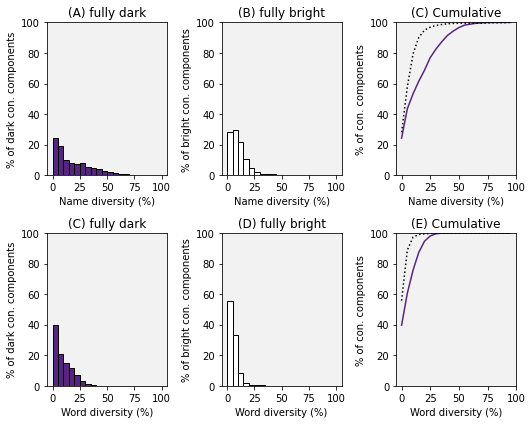

In [19]:
levels = ['Name diversity', 'Word diversity']
modes = ['fully dark', 'fully bright']
panel = ['A', 'B', 'C', 'D', 'E', 'F']

fig, ax = plt.subplots(len(levels), len(modes)+1, figsize=(2.5*(len(modes)+1), 3*len(levels)))
percentage_dufs = []

count = 0
for i, level in enumerate(levels):
    cumulative = {i: [] for i in modes}
    
    for j, mode in enumerate(modes): 
        tmp = collected_counts.loc[collected_counts['Darkness class'] == mode]

        h,_ = np.histogram(tmp[level], bins=[i for i in range(0, 105, 5)])
        n_dark = h[0]
        h = h*100/sum(h)

        if mode == 'fully dark':
            colors = ['#57257F' for i in range(len(h))]
        else:
            colors = ['white' for i in range(len(h))]

        x = list(range(len(h)))
        y = list(h)

        ax[i][j].bar(x,y,1, align='edge', color=colors, edgecolor='k')
        ax[i][j].set_facecolor('#F2F2F2')
        ax[i][j].set_xticks(range(0,21,5))
        ax[i][j].set_xticklabels(range(0,101,25))
        ax[i][j].set_ylabel('% of {} con. components'.format(mode.split(' ')[1]))
        ax[i][j].set_xlabel('{} (%)'.format(level))

        ax[i][j].title.set_text('({}) {}'.format(panel[count], mode))

        ax[i][j].set_ylim(0,100)
        
        cumulative[mode] = np.cumsum(h)
        count += 1
    
    j += 1
    for mode in modes:
        if mode == 'fully dark':
            color = '#57257F'
            linestyle = '-'
        else:
            color = 'black'
            linestyle = ':'
        
        ax[i][j].plot(x, cumulative[mode], color=color, linestyle=linestyle)
        ax[i][j].set_facecolor('#F2F2F2')
        ax[i][j].set_xticks(range(0,21,5))
        ax[i][j].set_xticklabels(range(0,101,25))
        ax[i][j].set_ylabel('% of con. components')
        ax[i][j].set_xlabel('{} (%)'.format(level))

        ax[i][j].title.set_text('({}) Cumulative'.format(panel[count]))

        ax[i][j].set_ylim(0,100)
        
plt.tight_layout()
plt.savefig('plots/AFDBv4_uniref50_histogram_components_word_diversity.pdf')
plt.savefig('plots/AFDBv4_uniref50_histogram_components_word_diversity.png', dpi=2000)
    

In [20]:
collected_counts.groupby(['Darkness class'])['Word diversity'].agg([np.mean, np.std, np.median])

,mean,std,median
Darkness class,,,
fully bright,5.331257,4.229020,4.430519
fully dark,9.698240,8.045313,7.357860


In [21]:
scipy.stats.kstest(collected_counts.loc[collected_counts['Darkness class'] == 'fully dark']['Word diversity'], collected_counts.loc[collected_counts['Darkness class'] == 'fully bright']['Word diversity'])

KstestResult(statistic=0.29005932625680464, pvalue=1.1102230246251565e-16)

In [22]:
collected_counts.groupby(['Darkness class'])['Name diversity'].agg([np.mean, np.std, np.median])

,mean,std,median
Darkness class,,,
fully bright,10.415991,9.450194,8.571429
fully dark,18.664570,16.324770,12.962963


In [23]:
collected_counts.loc[collected_counts['Darkness class'] == 'fully bright'].sort_values(by='Word diversity', ascending=False)

,No. entries,No. unique names,Word diversity,Darkness class,Most freq. source,Source freq,Name diversity
Subgraph,,,,,,,
100340,50,33,37.383178,fully bright,Reviewed,84.000000,66.000000
60703,74,70,36.244541,fully bright,Reviewed,63.513514,94.594595
39674,56,56,35.502959,fully bright,HAMAP-Rule,98.214286,100.000000
222476,57,57,35.087719,fully bright,HAMAP-Rule,98.245614,100.000000
59609,68,68,34.975369,fully bright,HAMAP-Rule,94.117647,100.000000
...,...,...,...,...,...,...,...
528,4729,9,0.074188,fully bright,HAMAP-Rule,93.000634,0.190315
549,18469,43,0.064561,fully bright,EMBL,99.962099,0.232823
807,14717,65,0.049301,fully bright,EMBL,75.769518,0.441666


In [24]:
collected_counts.loc[collected_counts['Darkness class'] == 'fully dark'].sort_values(by='Word diversity', ascending=False)

,No. entries,No. unique names,Word diversity,Darkness class,Most freq. source,Source freq,Name diversity
Subgraph,,,,,,,
3314,54,43,45.355191,fully dark,Google,94.444444,79.629630
91789,54,30,40.935673,fully dark,Google,98.148148,55.555556
24120,62,46,38.356164,fully dark,Google,98.387097,74.193548
10980,55,32,38.121547,fully dark,Google,90.909091,58.181818
7299,61,44,38.034188,fully dark,Google,93.442623,72.131148
...,...,...,...,...,...,...,...
14963,610,3,0.383352,fully dark,Google,92.950820,0.491803
2107,997,8,0.303337,fully dark,EMBL,52.557673,0.802407
147,3496,34,0.303331,fully dark,EMBL,70.652174,0.972540


In [25]:
selected_for_pfam = collected_counts.loc[(collected_counts['Darkness class'] == 'fully dark') & (collected_counts['Most freq. source'] == 'Google') & (collected_counts['Word diversity'] > 20)].sort_values(by='Word diversity', ascending=False)
selected_for_pfam

,No. entries,No. unique names,Word diversity,Darkness class,Most freq. source,Source freq,Name diversity
Subgraph,,,,,,,
3314,54,43,45.355191,fully dark,Google,94.444444,79.629630
91789,54,30,40.935673,fully dark,Google,98.148148,55.555556
24120,62,46,38.356164,fully dark,Google,98.387097,74.193548
10980,55,32,38.121547,fully dark,Google,90.909091,58.181818
7299,61,44,38.034188,fully dark,Google,93.442623,72.131148
...,...,...,...,...,...,...,...
29906,60,22,20.245399,fully dark,Google,100.000000,36.666667
80841,71,23,20.197044,fully dark,Google,95.774648,32.394366
6312,56,27,20.179372,fully dark,Google,100.000000,48.214286


In [26]:
import shutil

outfolder = 'data_generated/uniprot_naming_assessment/selected_for_pfam'
if not os.path.isdir(outfolder):
    os.mkdir(outfolder)

In [28]:
for subgraph in selected_for_pfam.index:
    
    curr_fasta = 'data_generated/uniprot_naming_assessment/AFDB90v4_subgraph_{}_uniprot_names_08022023.fasta'.format(subgraph)
    curr_csv   = 'data_generated/uniprot_naming_assessment/AFDB90v4_subgraph_{}_uniprot_names_08022023.csv'.format(subgraph)
    
    shutil.copyfile(curr_fasta, '{}/{}'.format(outfolder, curr_fasta.split('/')[-1]).replace('AFDB90v4_subgraph', 'Component'))
    shutil.copyfile(curr_csv, '{}/{}'.format(outfolder, curr_csv.split('/')[-1]).replace('AFDB90v4_subgraph', 'Component'))
